<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Custom_Image_Classification_EdgeTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Which GPU?
!nvidia-smi

Fri Apr 17 03:24:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Installing this version for following issues: 
- https://github.com/tensorflow/tensorflow/issues/38062
- https://github.com/tensorflow/tensorflow/issues/38232

In [0]:
!pip install tensorflow-gpu==2.1.0

In [3]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# Other imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

In [0]:
# Gather Flowers-17 dataset
data_root = tf.keras.utils.get_file(
  "/content/flower_photos", "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
   untar=True)

In [0]:
# Untar the dataset
!tar -xvf flower_photos.tar.gz

In [7]:
# All the paths of the flowers
ALL_IMG_PATHS = list(paths.list_images("flower_photos"))
print(ALL_IMG_PATHS[:10])

['flower_photos/tulips/15976769174_1d50f46ca1_m.jpg', 'flower_photos/tulips/7266196114_c2a736a15a_m.jpg', 'flower_photos/tulips/4571993204_5b3efe0e78.jpg', 'flower_photos/tulips/2431737309_1468526f8b.jpg', 'flower_photos/tulips/8838354855_c474fc66a3_m.jpg', 'flower_photos/tulips/10686568196_b1915544a8.jpg', 'flower_photos/tulips/8687675254_c93f50d8b0_m.jpg', 'flower_photos/tulips/15632065904_0d9caf174b.jpg', 'flower_photos/tulips/8520488975_a50d377f91.jpg', 'flower_photos/tulips/5700466891_2bcb17fa68_n.jpg']


In [8]:
# Shuffle the image paths and preview
random.shuffle(ALL_IMG_PATHS)
ALL_IMG_PATHS[:5]

['flower_photos/daisy/5110107234_12ddc0206b_m.jpg',
 'flower_photos/roses/12045735155_42547ce4e9_n.jpg',
 'flower_photos/sunflowers/24459750_eb49f6e4cb_m.jpg',
 'flower_photos/dandelion/3398195641_456872b48b_n.jpg',
 'flower_photos/tulips/4300258119_b03f2f956e.jpg']

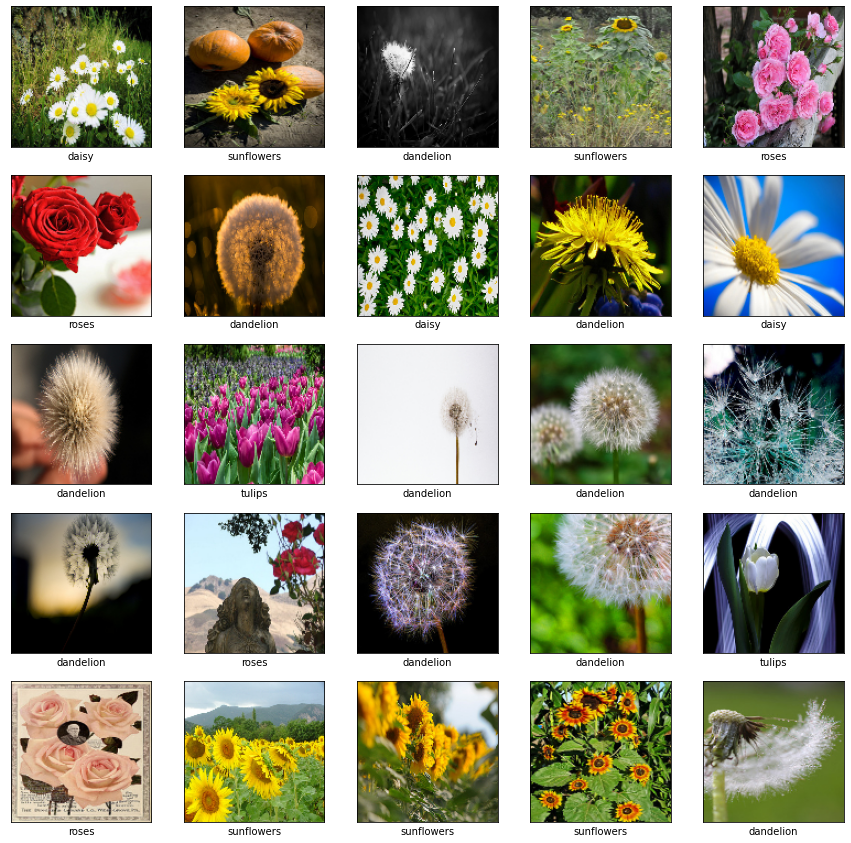

In [9]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [0]:
# Going for a 0.15 validation split
nb_test_images = int(len(list(paths.list_images("flower_photos"))) * 0.15)
nb_train_images = len(list(paths.list_images("flower_photos"))) - nb_test_images

In [0]:
# Specify the directory paths
train_dir = "train"
val_dir = "val"

In [0]:
def move_images(nb_images, output_dir):
    # iterate through the number of images
    for i in tqdm(range(nb_images)):
        # grab an image path and grab the label of the image
        image_path = ALL_IMG_PATHS[i]
        # careful about the index of the split
        label = image_path.split("/")[1]
        
        # check if a directory for the label exists, if not create it
        new_image_dir = os.path.join(output_dir, label)
        if not os.path.exists(new_image_dir):
            os.makedirs(new_image_dir)
            
        # copy the current image to the respective folder
        shutil.copy2(image_path, new_image_dir)

In [13]:
# Prepare the train and test set
move_images(nb_train_images, train_dir)
move_images(nb_test_images, val_dir)

100%|██████████| 550/550 [00:00<00:00, 4825.42it/s]


In [14]:
# Setup data generators
train_aug = ImageDataGenerator(rescale=1/255.)
val_aug = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_directory("train",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=32
)
val_gen = train_aug.flow_from_directory("val",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32
)

Found 3120 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [16]:
# Get the class labels, these will be required later
# Reference: https://colab.sandbox.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf1.ipynb
print (train_gen.class_indices)
labels = '\n'.join(sorted(train_gen.class_indices.keys()))
with open('flower_labels.txt', 'w') as f:
    f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [17]:
!cat flower_labels.txt

daisy
dandelion
roses
sunflowers
tulips

In [18]:
# Load the MobileNetV2 model but exclude the classification layers
EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 2s 0us/step


In [0]:
def get_training_model():
    # We are fine-tuning the extractor model
    EXTRACTOR.trainable = True
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

Since we are fine-tuning a pre-trained network it'd be prudent to not break the weights of that pre-trained network too fast. So the idea is to start with a relatively lower learning rate and then increase it gradually.

In [0]:
# LR schedule configuration
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

LR schedule comes from [here](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_xception_fine_tuned_best.ipynb). 

In [0]:
# LR schedule
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

1e-05 2.6384000000000004e-05


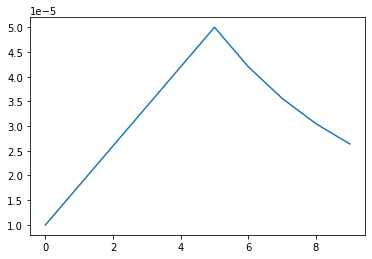

In [22]:
# How does the LR schedule looks like?
rng = [i for i in range(10)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

To calculate the number of the images in `train` and `val` directories let's use the `imutils` library. This would be needed for calculating the steps. 

In [23]:
len(list(paths.list_images("train"))), len(list(paths.list_images("val")))

(3120, 550)

In [24]:
# Train the model
flower_model = get_training_model()
start = time.time()
history = flower_model.fit(train_gen,
              steps_per_epoch=3120//32,
              validation_data=val_gen,
              validation_steps=550//32,
              epochs=10,
              callbacks=[lr_callback])
print("Total training time: ",time.time()-start)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 97 steps, validate for 17 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/10
97/97 [==============================] - 42s 430ms/step - loss: 1.5370 - accuracy: 0.3695 - val_loss: 1.1613 - val_accuracy: 0.5294

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/10
97/97 [==============================] - 30s 311ms/step - loss: 0.8640 - accuracy: 0.6794 - val_loss: 0.7339 - val_accuracy: 0.7151

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
Epoch 3/10
97/97 [==============================] - 30s 311ms/step - loss: 0.4907 - accuracy: 0.8352 - val_loss: 0.4859 - val_accuracy: 0.8180

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
Epoch 4/10
97/97 [==============================] - 30s 311ms/step - loss: 0.3032 - accuracy: 0.9003 - val_loss: 0.3705 - val_accuracy: 0.8621

Epoch 00

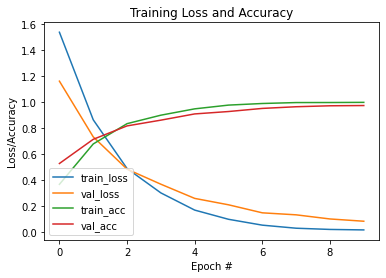

In [25]:
# Plotting the losses
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

Let's optimize this model with TF Lite in a way it would be compatible with the Edge TPU. To make the model fully int8-quantized, we would need to supply a representative dataset as shown [here](https://www.tensorflow.org/lite/performance/post_training_integer_quant). It needs the dataset to quantize the weights as well as the activations.

In [26]:
# Extract the image paths from the train set, shuffle them, and 
# choose 100 images
image_paths = list(paths.list_images("train"))
random.shuffle(image_paths)
image_paths = image_paths[:100]

# An empty list as a placeholder for the dataset
rep_ds = []

# Iterate over the image paths
for image in tqdm(image_paths):
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = plt.imread(image).astype("float32")
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, 0)
    image_pixels = image_pixels / 255.
    
    # Append to the list
    rep_ds.append(image_pixels)

100%|██████████| 100/100 [00:00<00:00, 321.33it/s]


In [0]:
# Convert to TensorFlow dataset
rep_ds = np.array(rep_ds)
rep_ds = tf.data.Dataset.from_tensor_slices((rep_ds))

In [0]:
# Creating a representative dataset for int quantization
def representative_dataset():
    for image in rep_ds.take(100):
        yield [image]

In [0]:
# TF Lite conversion 

# Instantiate the converter, instruct TF Lite to optimize for size, and
# specify the representative dataset
converter = tf.lite.TFLiteConverter.from_keras_model(flower_model) 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE] 
converter.representative_dataset = representative_dataset

# We are going for full INT8 quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convert finally
tflite_model = converter.convert()

Let's compare the sizes of the both the models. 

In [30]:
# Unoptimized (SavedModel format)
flower_model.save("flower_model_no_op")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: flower_model_no_op/assets


In [31]:
# Check size
!du --all -h flower_model_no_op

4.4M	flower_model_no_op/saved_model.pb
4.0K	flower_model_no_op/assets
44K	flower_model_no_op/variables/variables.index
140K	flower_model_no_op/variables/variables.data-00000-of-00002
34M	flower_model_no_op/variables/variables.data-00001-of-00002
34M	flower_model_no_op/variables
38M	flower_model_no_op


In [32]:
# Serialize the TFLite model and check it's size
!mkdir tflite_model

f = open("tflite_model/flower_model.tflite", "wb")
f.write(tflite_model)
f.close()

!du --all -h tflite_model

3.4M	tflite_model/flower_model.tflite
3.4M	tflite_model


See the reduction in model's size! Let's now evaluate this model on the validation dataset using the code listsings from [here](https://www.tensorflow.org/lite/performance/post_training_integer_quant#evaluate_the_models). Let's first load the TF Lite model into an interpreter. 

In [0]:
# Load the model into interpreters
interpreter_quant = tf.lite.Interpreter(model_content=tflite_model)
interpreter_quant.allocate_tensors()
input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

In [34]:
# Prepare validation sets
# Extract the image paths from the train set
image_paths = list(paths.list_images("val"))

# Empty labels for storing images and labels
val_images = []
val_labels = []

# Iterate over the image paths
for image in tqdm(image_paths):
    # Read the image from the current path, change the datatype, resize the image,
    # add batch dimension, normalize the pixel values
    image_pixels = plt.imread(image).astype("float32")
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, 0)
    image_pixels = image_pixels / 255.

    # Extract the label
    label = image.split("/")[1]
    
    # Append to the list
    val_images.append(image_pixels)
    val_labels.append(label)

# Create NumPy array
val_images = np.array(val_images)

100%|██████████| 550/550 [00:01<00:00, 297.67it/s]


In [0]:
# Define the class labels (should be alphabetical)
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

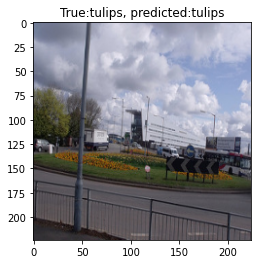

In [36]:
# Run a demo prediction
test_image = val_images[0]
interpreter_quant.set_tensor(input_index_quant, test_image)
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(output_index_quant)

# See the prediction
plt.imshow(val_images[0].squeeze())
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true=val_labels[0],
                              predict=str(CLASSES[np.argmax(predictions[0])])))
plt.grid(False)

In [0]:
# A helper function to evaluate the TF Lite model using "test" dataset.
# Comes from: https://www.tensorflow.org/lite/performance/post_training_integer_quant
def evaluate_model(interpreter):
  accurate_count = 0
  
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  predictions = []
  for val_image, val_label in zip(val_images, val_labels):
    interpreter.set_tensor(input_index, val_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    probability = interpreter.get_tensor(output_index)
    flower_id = np.argmax(probability[0])
    predictions.append(flower_id)
    
    # Compare prediction results with ground truth labels to calculate accuracy.
    if CLASSES[flower_id] == val_label:
      accurate_count += 1
  
  accuracy = accurate_count * 1.0 / len(predictions)

  return accuracy

In [39]:
# Check, check
print(evaluate_model(interpreter_quant))

0.9545454545454546


We can see that the accuracy loss is little. 

If you run into errors load the TF Lite model again into interpreter. Also,


> NOTE: Colab runs on server CPUs, and TensorFlow Lite currently
doesn't have super optimized server CPU kernels. So this part may be
slower than the above float interpreter. But for mobile CPUs, considerable
speedup can be observed.

Taken from [here](https://www.tensorflow.org/lite/performance/post_training_integer_quant).

Let's port this model with [Edge TPU compiler](https://coral.ai/docs/edgetpu/compiler/#). 

In [0]:
%%bash
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
sudo apt-get update
sudo apt-get install edgetpu-compiler

In [41]:
!edgetpu_compiler /content/tflite_model/flower_model.tflite

Edge TPU Compiler version 2.1.302470888

Model compiled successfully in 448 ms.

Input model: /content/tflite_model/flower_model.tflite
Input size: 3.33MiB
Output model: flower_model_edgetpu.tflite
Output size: 3.39MiB
On-chip memory used for caching model parameters: 3.29MiB
On-chip memory remaining for caching model parameters: 3.63MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 73
Operation log: flower_model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 71
Number of operations that will run on CPU: 2
See the operation log file for individual operation details.


We can see that most of the operations of the new compiled model can be executed on an [Edge TPU](https://coral.ai/docs/edgetpu/faq/) - "Number of operations that will run on Edge TPU: 71".

You can plug an Edge TPU USB accelerator in a supported device (supports Raspberry Pi as well :D) and follow [this documentation](https://coral.ai/docs/reference/edgetpu.classification.engine/) and [this tutorial](https://github.com/google-coral/tflite/blob/master/python/examples/classification/classify_image.py) to use the model we just compiled. 


In [0]:
# Download the Edge TPU compiled model and the labels' file
from google.colab import files
files.download("tflite_model/flower_model.tflite")
files.download("flower_model_edgetpu.tflite")
files.download("flower_labels.txt")

## To do:
- Add annotations before the cells. 